# Sentiments of the artists

In [1]:
import networkx as nx
import numpy as np
import requests
import matplotlib.pyplot as plt
from collections import Counter
from io import BytesIO
import re
from collections import defaultdict
import random
import pandas as pd


url = "https://raw.githubusercontent.com/fridapfrandsen/network-data/main/rock_network.gexf"

response = requests.get(url)
response.raise_for_status()

G = nx.read_gexf(BytesIO(response.content))

Get the LabMT wordlist

In [4]:
labmt_url = "https://raw.githubusercontent.com/fridapfrandsen/network-data/main/Data_Set_S1.txt"

response_labmt = requests.get(labmt_url)
response_labmt.raise_for_status()

labmt = pd.read_csv(BytesIO(response_labmt.content), sep="\t", skiprows=2)
labmt_dict = dict(zip(labmt["word"], labmt["happiness_average"]))

print(len(labmt_dict), "words loaded.")
print(list(labmt_dict.items())[:5])

10222 words loaded.
[('laughter', 8.5), ('happiness', 8.44), ('love', 8.42), ('happy', 8.3), ('laughed', 8.26)]


Function to calculate sentiment

In [5]:
def calc_sentiment(tokens):
    scores = []
    for token in tokens:
        token = token.lower()
        if token in labmt_dict:
            scores.append(labmt_dict[token])
    if scores:
        return np.mean(scores)
    else:
        return None

Calculate the sentiment of each node in the network and add it as an attribute

In [7]:
for node, data in G.nodes(data=True):
    text = data.get("wikitext")
    if not text:
        continue
    tokens = re.findall(r"\w+", text.lower())
    sentiment = calc_sentiment(tokens)
    G.nodes[node]["sentiment"] = sentiment

Calculate statistics about the sentiments

In [9]:
sentiments = [G.nodes[n]["sentiment"] for n in G.nodes() if not np.isnan(G.nodes[n]["sentiment"])]

mean_sent = np.mean(sentiments)
median_sent = np.median(sentiments)
var_sent = np.var(sentiments)
p25 = np.percentile(sentiments, 25)
p75 = np.percentile(sentiments, 75)
min = np.min(sentiments)
max = np.max(sentiments)

print(f"Mean: {mean_sent:.2f}")
print(f"Median: {median_sent:.2f}")
print(f"Variance: {var_sent:.4f}")
print(f"25th percentile: {p25:.2f}")
print(f"75th percentile: {p75:.2f}")
print(f"Minumum sentiment: {min:.2f}")
print(f"Maximum sentiment: {max:.2f}")

Mean: 5.53
Median: 5.53
Variance: 0.0072
25th percentile: 5.50
75th percentile: 5.57
Minumum sentiment: 4.18
Maximum sentiment: 5.85


Plotting the sentiment values

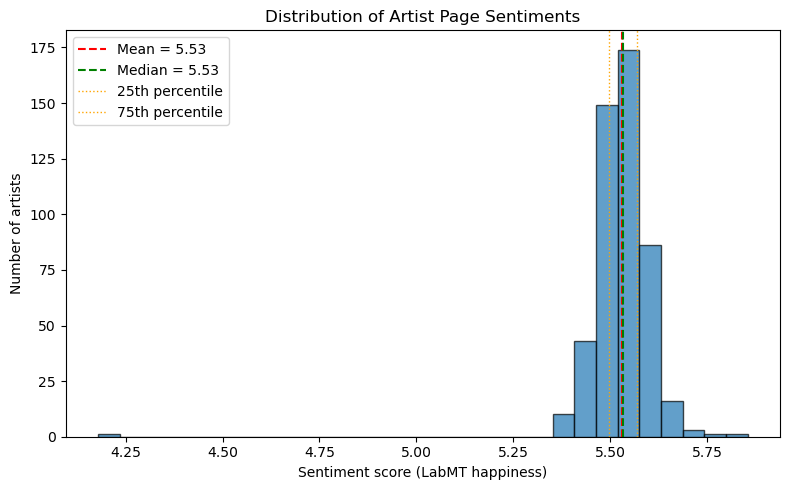

In [11]:
plt.figure(figsize=(8,5))
plt.hist(sentiments, bins=30, edgecolor='black', alpha=0.7)

plt.axvline(mean_sent, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {mean_sent:.2f}")
plt.axvline(median_sent, color='green', linestyle='dashed', linewidth=1.5, label=f"Median = {median_sent:.2f}")
plt.axvline(p25, color='orange', linestyle='dotted', linewidth=1, label='25th percentile')
plt.axvline(p75, color='orange', linestyle='dotted', linewidth=1, label='75th percentile')

plt.title("Distribution of Artist Page Sentiments")
plt.xlabel("Sentiment score (LabMT happiness)")
plt.ylabel("Number of artists")
plt.legend()
plt.tight_layout()
plt.show()

The ten happiest and saddest pages:

In [12]:
node_sentiments = [(n, d["sentiment"]) for n, d in G.nodes(data=True) if not np.isnan(d["sentiment"])]
sorted_nodes = sorted(node_sentiments, key=lambda x: x[1])

saddest = sorted_nodes[:10]
happiest = sorted_nodes[-10:]

print("\n😢 Saddest pages:")
for n, s in saddest:
    print(f"{n}: {s:.2f}")

print("\n😄 Happiest pages:")
for n, s in happiest:
    print(f"{n}: {s:.2f}")


😢 Saddest pages:
Poison_(American_band): 4.18
Gary_Glitter: 5.38
Marilyn_Manson: 5.39
Sex_Pistols: 5.39
Skid_Row_(American_band): 5.40
Rage_Against_the_Machine: 5.40
Canned_Heat: 5.40
Five_Finger_Death_Punch: 5.40
Quiet_Riot: 5.40
Pantera: 5.40

😄 Happiest pages:
Counting_Crows: 5.65
Royal_Blood_(band): 5.66
Train_(band): 5.67
The_Cardigans: 5.67
Fun_(band): 5.67
Michael_Martin_Murphey: 5.69
The_Boxtones: 5.69
Tracy_Chapman: 5.74
Lenny_Kravitz: 5.75
Dallas_Green_(musician): 5.85


As we can see from the calculated sentiments and the affilitated statstics, all the pages have close to the same sentiment. The variance is only 0.0072. This makes sence, since the wikipedia pages are (ideally) obejctive and hence should have a relativly average sentiment.